# Project Description and Goals

Insert brief description

### Objectives for this project include:
- Identifying ____.
- Documenting process and analysis throughout the data science pipeline.
- Demonstrating the information that was discovered.
- Deliverables:
    - [README.md](insert link) file containing overall project information, how to reproduce work, and notes from project planning.
    - Jupyter Notebook Report detailing the pipeline process.
    - Python module that automates the data [wrangling](insert link).

### Pipeline Process:
1. Acquire
2. Prepare
3. Explore
4. Model/Evaluate
5. Deliver

### Initial Questions
- Does the data increase, decrease, or stay the same over time?
- What is the distribution of yearly average temperature and yearly average uncertainty?
- What is the distribution of monthly average temperature and monthly average uncertainty?

***
### Project Imports

In [1]:
import numpy as np
import pandas as pd

import wrangle

#visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#for presentation purposes
import warnings
warnings.filterwarnings("ignore")

#working with dates
from datetime import timedelta, datetime

#evaluate performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

#time series analysis
import statsmodels.api as sm

#holt's linear trend model
from statsmodels.tsa.api import Holt

***
# Data Acquisition

In [2]:
#get the dataframe using wrangle.py script
df = wrangle.get_temps_data()
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil


In [3]:
#rows and columns
df.shape

(645675, 5)

In [4]:
#list of column names and data types with more information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645675 entries, 0 to 645674
Data columns (total 5 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             645675 non-null  object 
 1   AverageTemperature             620027 non-null  float64
 2   AverageTemperatureUncertainty  620027 non-null  float64
 3   State                          645675 non-null  object 
 4   Country                        645675 non-null  object 
dtypes: float64(2), object(3)
memory usage: 24.6+ MB


In [5]:
#check nulls
df.isnull().sum()

dt                                   0
AverageTemperature               25648
AverageTemperatureUncertainty    25648
State                                0
Country                              0
dtype: int64

In [6]:
#check nulls in Texas
df[df.State.str.contains("Texas")].isnull().sum()

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
State                            0
Country                          0
dtype: int64

In [7]:
#summary statistics for numeric columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AverageTemperature,620027.0,8.993111,13.772150,-45.389,-0.693,11.199,19.899,36.339
AverageTemperatureUncertainty,620027.0,1.287647,1.360392,0.036,0.316,0.656,1.850,12.646


array([[<AxesSubplot:title={'center':'AverageTemperature'}>,
        <AxesSubplot:title={'center':'AverageTemperatureUncertainty'}>]],
      dtype=object)

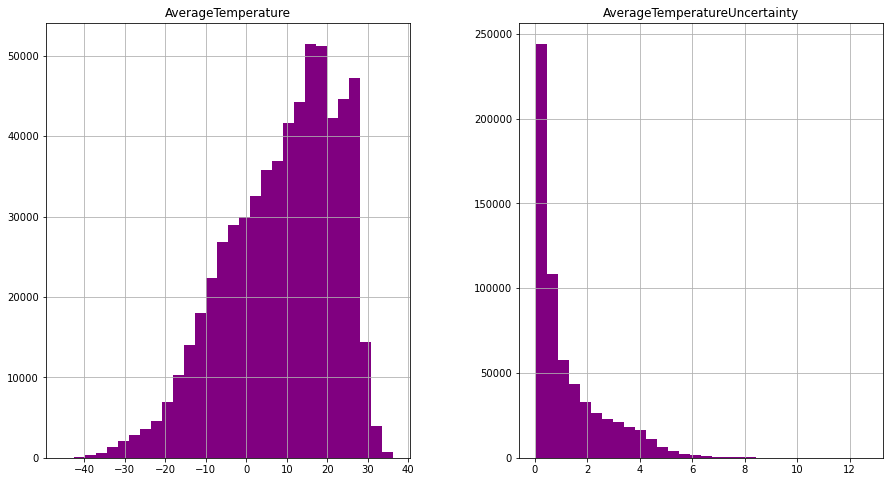

In [8]:
#initial plots
df.hist(bins=30,figsize=(15,8),color='purple')

### Findings
- dataset has lots of rows and needs to be cut down to soley Texas temperatures for this project.
- column names look messy and need better names for readability.
- date column (`dt`) is an object and needs to be converted to datetime dtype.
- `dt` should be set as index.
- need to drop `Country` and `State` columns since I will just be working with Texas data.
- nulls exist in the full data set, but not for temperatures in Texas, so no values need to be filled in.

***
# Data Preparation

In [9]:
#grab cleaned dataframe using the clean_temps function in wrangle.py
df = wrangle.clean_temps(df)
df.head()

,avg_temp,avg_uncertainty
date,,
1820-01-01,4.489,3.369
1820-02-01,9.081,2.873
1820-03-01,12.657,2.423
1820-04-01,19.215,2.501
1820-05-01,22.577,2.495


In [10]:
#double check columns, nulls and dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2325 entries, 1820-01-01 to 2013-09-01
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   avg_temp         2325 non-null   float64
 1   avg_uncertainty  2325 non-null   float64
dtypes: float64(2)
memory usage: 54.5 KB


In [11]:
#split the data using the split function in wrangle.py
train, validate, test = wrangle.split(df)

print('overall shape of dataframe:', df.shape)
print('train:', train.shape)
print('validate:', validate.shape)
print('test:', test.shape)

overall shape of dataframe: (2325, 2)
train: (1162, 2)
validate: (697, 2)
test: (466, 2)


#### Data is:
- cleaned/prepped
- split into train, validate, test for exploration.
- ready to be explored on training (in-sample) data.

***
# Data Exploration
Answer questions posed in planning/brainstorming

In [27]:
#add month and year column
train['month'] = train.index.month
train['year'] = train.index.year

train.head()

,avg_temp,avg_uncertainty,month,year
date,,,,
1820-01-01,4.489,3.369,1,1820
1820-02-01,9.081,2.873,2,1820
1820-03-01,12.657,2.423,3,1820
1820-04-01,19.215,2.501,4,1820
1820-05-01,22.577,2.495,5,1820


In [65]:
#set target y variables
y = train.avg_temp
y_unc = train.avg_uncertainty

y.head(), y_unc.head()

(date
 1820-01-01     4.489
 1820-02-01     9.081
 1820-03-01    12.657
 1820-04-01    19.215
 1820-05-01    22.577
 Name: avg_temp, dtype: float64,
 date
 1820-01-01    3.369
 1820-02-01    2.873
 1820-03-01    2.423
 1820-04-01    2.501
 1820-05-01    2.495
 Name: avg_uncertainty, dtype: float64)

#### Does the data increase, decrease, or stay the same over time?

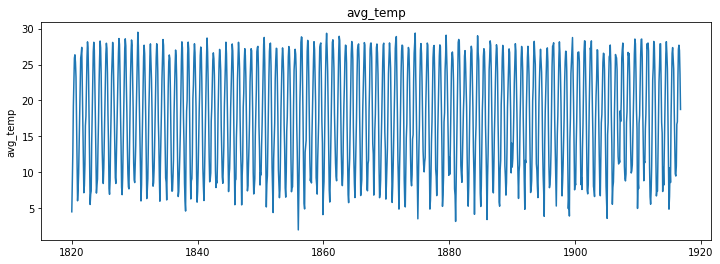

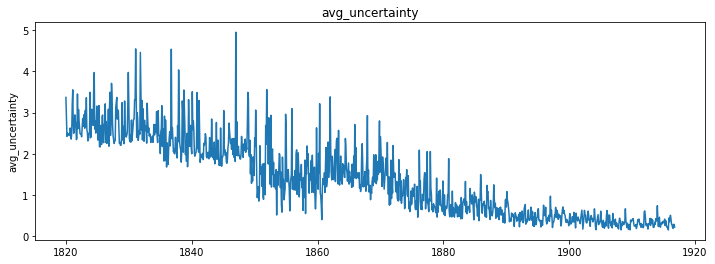

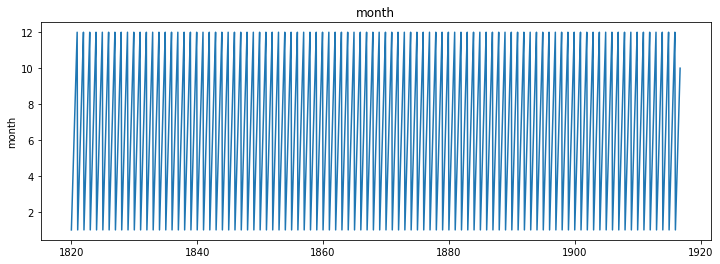

In [25]:
#loop to visualize avg temp/avg temp uncertainty over time
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

#### What is the distribution of yearly average temperature and yearly average uncertainty?

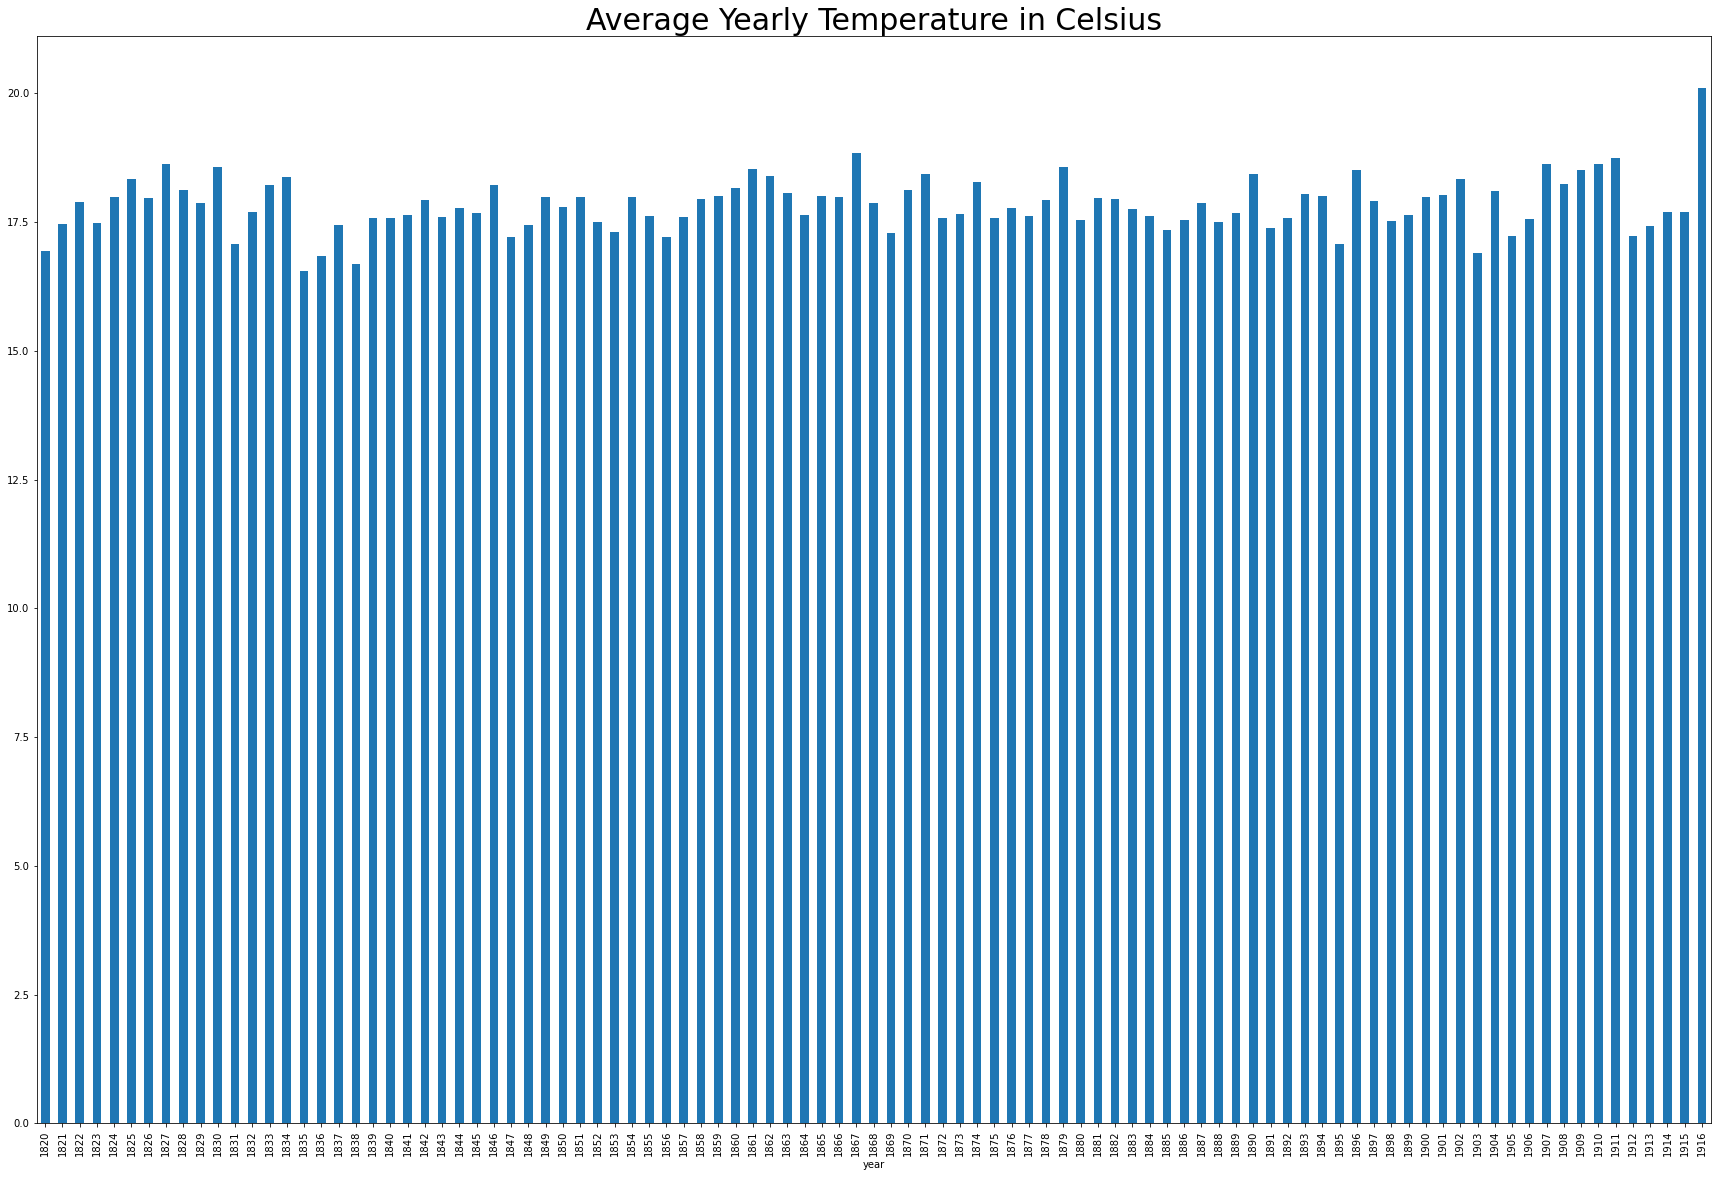

In [46]:
#yearly average temperature
train.groupby('year').avg_temp.mean().plot.bar(figsize=(30,20))
plt.title('Average Yearly Temperature in Celsius', fontsize=30)
plt.show()

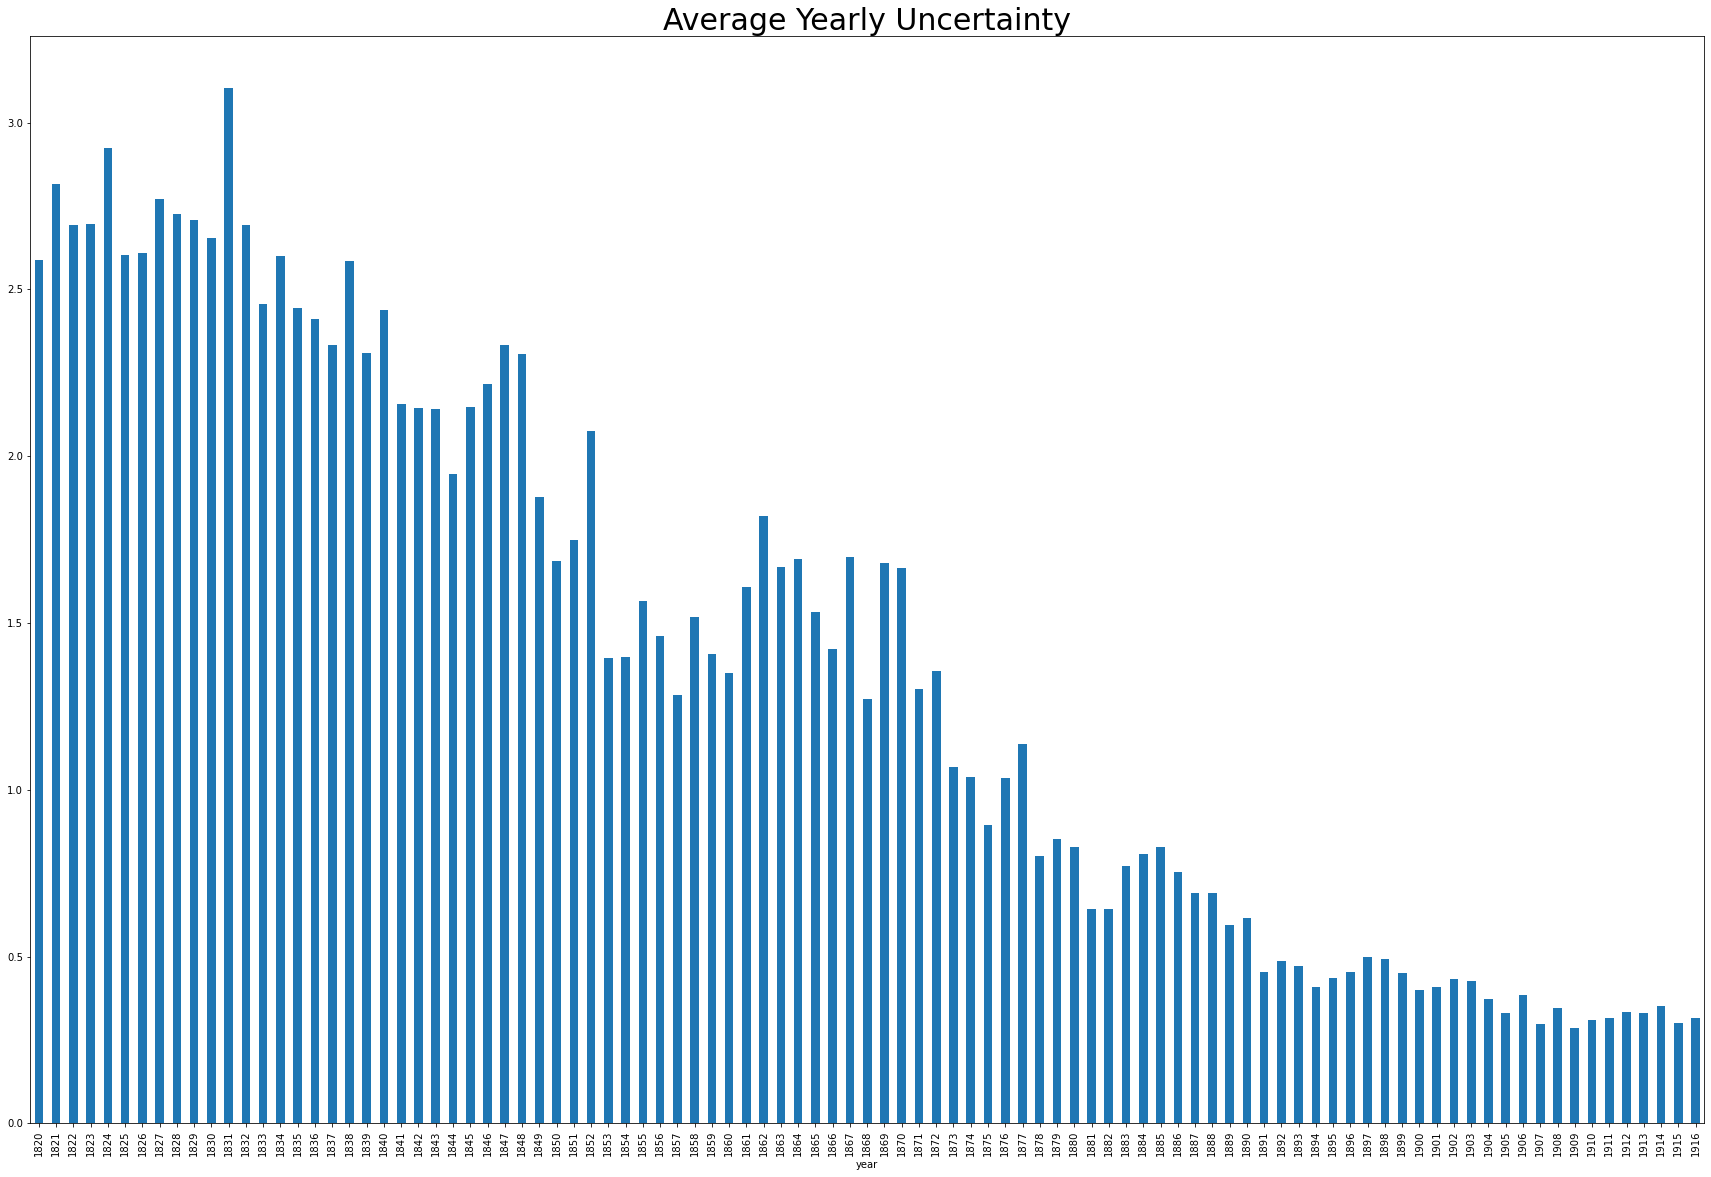

In [51]:
#yearly average uncertainty
train.groupby('year').avg_uncertainty.mean().plot.bar(figsize=(30,20))
plt.title('Average Yearly Uncertainty', fontsize=30)
plt.show()

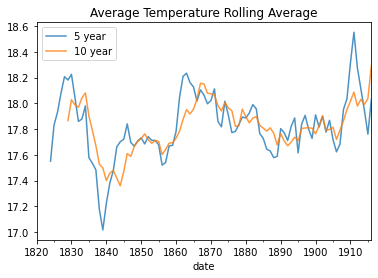

In [71]:
#reducing noise by resampling avg_temp data and rolling averages
y.resample('Y').mean().rolling(5).mean().plot(alpha=.8, label='5 year')
y.resample('Y').mean().rolling(10).mean().plot(alpha=.8, label='10 year')
plt.legend()
plt.title('Average Temperature Rolling Average')
plt.show()

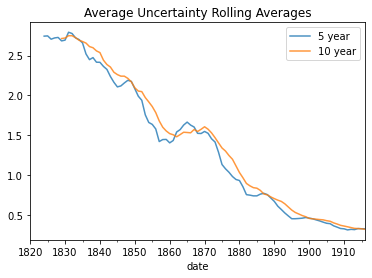

In [70]:
#reducing noise by resampling avg_uncertainty and rolling averages
y_unc.resample('Y').mean().rolling(5).mean().plot(alpha=.8, label='5 year')
y_unc.resample('Y').mean().rolling(10).mean().plot(alpha=.8, label='10 year')
plt.legend()
plt.title('Average Uncertainty Rolling Averages')
plt.show()

#### What is the distribution of monthly average temperature and monthly average uncertainty?

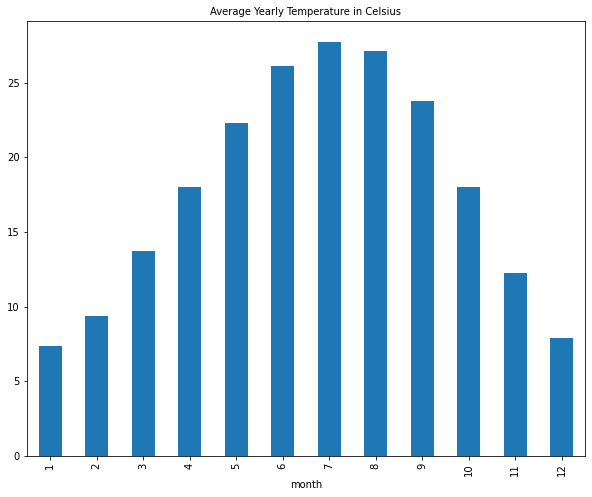

In [56]:
#monthly average temperature
train.groupby('month').avg_temp.mean().plot.bar(figsize=(10,8))
plt.title('Average Yearly Temperature in Celsius', fontsize=10)
plt.show()

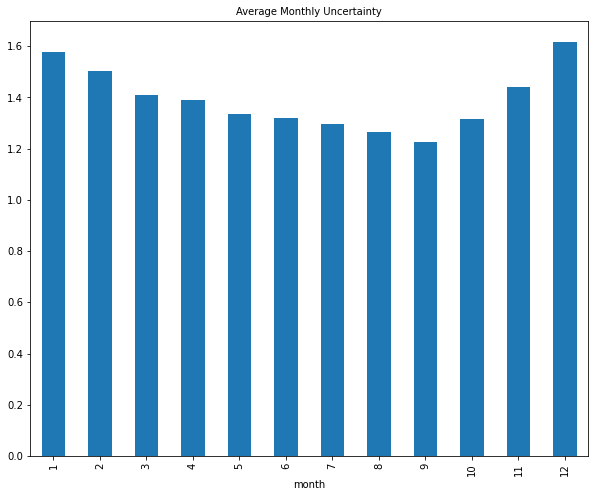

In [57]:
#monthly average uncertainty
train.groupby('month').avg_uncertainty.mean().plot.bar(figsize=(10,8))
plt.title('Average Monthly Uncertainty', fontsize=10)
plt.show()

### Takeaways
- 

***
# Data Modeling / Evaluation

In [69]:
#apply predictions to observations
def make_predictions():
    yhat_df = pd.DataFrame({'avg_temp': [avg_temp],
                           'avg_uncertainty': [avg_uncertainty]}, 
                           index = validate.index)
    return yhat_df

#compute mean squared error and root mean squared error to evaluate
def evaluate(target_var):
    '''
    This function will take the actual values of the target variable from validate,
    and the predicted values stored in yhat_df,
    compute the rmse, rounding to 0 decimal places,
    and it will return the rmse.

    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse


#use evaluate function and plot train, validate, and test values with the predicted values to compare performance
def plot_and_eval(target_var):
    '''
    This function takes in the target variable name (string),
    and returns a plot of the values of train for that variable, validate, and the predicted values from y_hat_df.
    It will also label the rmse.
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()
    
    
    
#empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

#function to store the rmse to compare models
def append_eval_df(model_type, target_var):
    '''
    This function takes in the type of model run and name of target variable as arguments.
    It returns the eval_df with the rmse appended to it for that model and target variable
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

### Last Observed Value
Predict all future values to be the last observed value.


### Simple Average
Take the simple average of historical values and use that value to predict future values.


### Moving Average
Use a specified moving average to forecast. In other words, the average over the last specified time will be used as the forecasted value.

### Holt's Linear Trend
Exponential smoothing applied to both the average and the trend (slope).

- $\alpha$ / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.
- $\beta$ / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values.

***
# Conclusion